In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

In [51]:
df = pd.read_csv("../../data/small/attack-sum-count.csv")
df["date"] = pd.to_datetime(df.loc[:, ["year", "month", "day", "hour"]])
df.drop(columns=["year", "month", "day", "hour"], inplace=True)
df.set_index("date", inplace=True)
df

,sumCount
date,
2019-09-23 07:00:00,1878655
2019-09-19 10:00:00,1654071
2019-09-17 16:00:00,1677510
2019-09-18 18:00:00,1664228
2019-09-19 06:00:00,1534700
...,...
2019-09-04 23:00:00,1261044
2019-09-29 00:00:00,1602877
2018-09-26 00:00:00,1657392


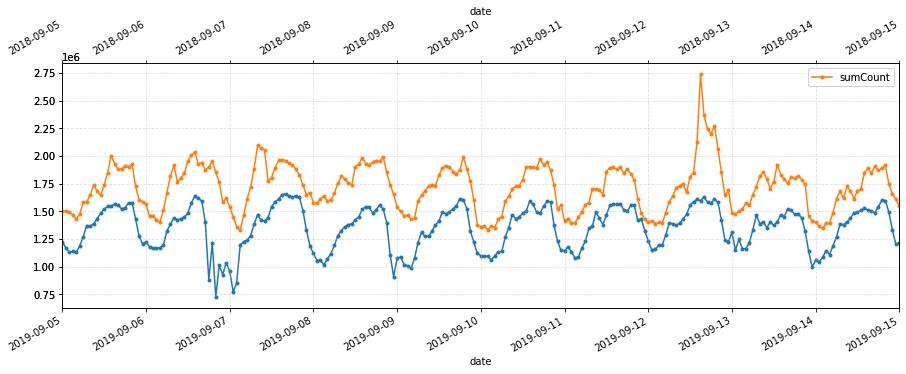

In [60]:
fig, ax1 = plt.subplots(figsize=(15,5))
df[df.index.year == 2019].plot(ax=ax1, marker=".", label="2019")
ax2 = ax1.twiny()
df[df.index.year == 2018].plot(ax=ax2, color="C1", marker=".", label="2018")

ax1.set_xlim("2019-09-05", "2019-09-15")
ax2.set_xlim("2018-09-05", "2018-09-15")
plt.grid(linestyle="--", alpha=0.4)
plt.show()

In [55]:
df2 = pd.read_parquet("../../data/small/A1.parquet")
df2["date"] = pd.to_datetime(df2.loc[:, ["year", "month", "day", "hour"]])
df2.drop(columns=["year", "month", "day", "hour"], inplace=True)
df2.set_index("date", inplace=True)
df2

,trafficType,domain,sumCount
date,,,
2018-09-01 00:00:00,user,cs.wiktionary,54
2018-09-01 00:00:00,user,tg.wiktionary,5
2018-09-01 00:00:00,user,tn.wikipedia,4
2018-09-01 00:00:00,spider,bh.wikipedia,57
2018-09-01 00:00:00,spider,la.wikisource,20
...,...,...,...
2019-09-30 23:00:00,spider,ht.wikisource,28
2019-09-30 23:00:00,spider,ug.wikiquote,12
2019-09-30 23:00:00,spider,ceb.wikipedia,1545


In [157]:
def getdfcols(df):
    l = [df.index.to_numpy()]
    try:
        for c in df.columns:
            l.append(df[c].to_numpy())
    except AttributeError:
        # its probably a series ...
        l.append(df.to_numpy())
    return l

In [158]:
df_spider = df2[df2["trafficType"]=="spider"].groupby(["date"]).sum(["sumCount"])
df_user = df2[df2["trafficType"]=="user"].groupby(["date"]).sum(["sumCount"])

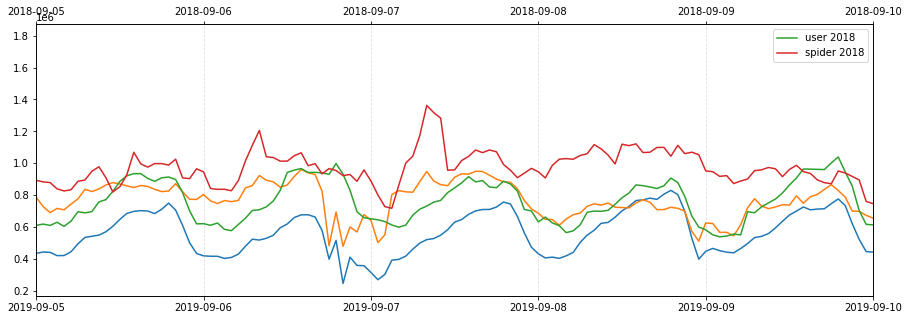

In [159]:
fig, ax1 = plt.subplots(figsize=(15,5))
ax1.plot(df_user[df_user.index.year == 2019], label="user 2019", color="C0")
ax1.plot(df_spider[df_spider.index.year == 2019], label="spider 2019", color="C1")
ax2 = ax1.twiny()
ax2.plot(df_user[df_user.index.year == 2018], label="user 2018", color="C2")
ax2.plot(df_spider[df_spider.index.year == 2018], label="spider 2018", color="C3")

ax1.set_xlim(datetime.date(2019, 9, 5), datetime.date(2019, 9, 10))
ax2.set_xlim(datetime.date(2018, 9, 5), datetime.date(2018, 9, 10))
plt.grid(linestyle="--", alpha=0.4)
plt.legend()
plt.show()

In [186]:
df2.index.day

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
           dtype='int64', name='date', length=2283395)

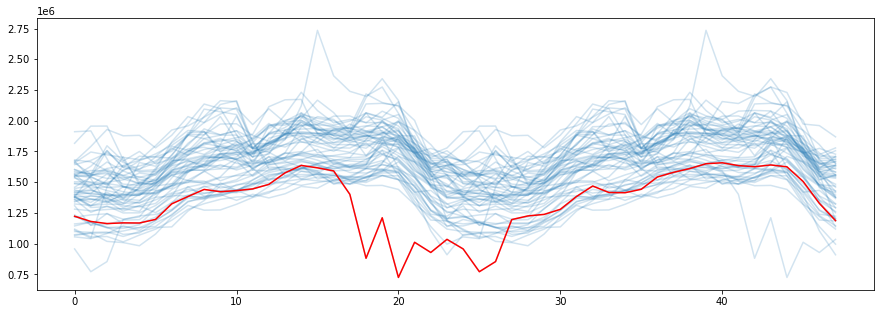

In [199]:
df4 = df2.groupby([df2.index.year, df2.index.day, df2.index.hour])["sumCount"].sum()
df4.rename_axis(index=["year", "day", "hour"], inplace=True)

years = df4.index.get_level_values("year").unique().to_numpy()
days = df4.index.get_level_values("day").unique().to_numpy()

fig, ax = plt.subplots(figsize=(15,5))

for year in years:
    for day, nextday in zip(days[:-1], days[:-1]+1):
        _, y = getdfcols(df4.loc[year].loc[day:nextday])
        x = np.arange(0, 48)
        ax.plot(x, y, "-", alpha=0.2, color="C0")
ax.plot()
attack_df2 = df2.loc[datetime.datetime(2019, 9, 6, 0):datetime.datetime(2019, 9, 7, 23)]
attack_per_hour = attack_df2.groupby([attack_df2.index.day, attack_df2.index.hour]).sum("sumCount")
ax.plot(x, attack_per_hour, color="red")
plt.show()

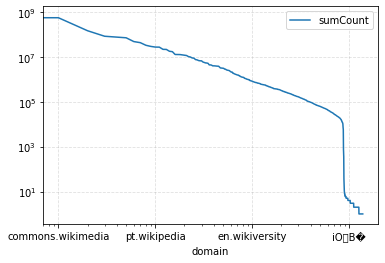

In [333]:
dfg = df2.groupby("domain").sum("sumCount").sort_values("sumCount", ascending=False)
dfg.plot(loglog=True)
plt.grid(linestyle="--", alpha=0.4)

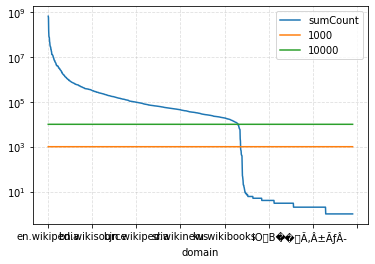

In [334]:
dfg.plot(logy=True, linestyle="-")
plt.plot(dfg.index, [1000]*len(dfg), label="1000")
plt.plot(dfg.index, [10000]*len(dfg), label="10000")
plt.grid(linestyle="--", alpha=0.4, which="both")
plt.legend()
plt.show()

In [438]:
treshold = 100000
topn = 8
# doing treshold with fixed view number
df_treshold = df2[["sumCount", "domain"]].groupby("domain").transform("sum").transform(lambda row: row > treshold)
# doing treshold with top n entries
df_topn = df2[["sumCount", "domain"]].groupby("domain").sum("sumCount").sort_values("sumCount", ascending=False)[0:topn]
df_treshold = df2.domain.isin(df_topn.index).to_frame().rename(columns={"domain": "sumCount"})

In [439]:
df6 = df2.copy()
df6.loc[df_treshold["sumCount"], "newDomain"] = df6[df_treshold["sumCount"]].domain
df6.loc[~df_treshold["sumCount"], "newDomain"] = "combined.domain"
print(len(df6.newDomain.unique()))

9


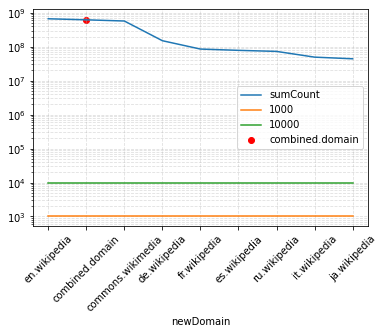

In [440]:
# plt.figure()
dfg2 = df6.groupby("newDomain").sum("sumCount").sort_values("sumCount", ascending=False)
dfg2.plot(logy=True, linestyle="-")
plt.plot(dfg2.index, [1000]*len(dfg2), label="1000")
plt.plot(dfg2.index, [10000]*len(dfg2), label="10000")
plt.xticks(rotation=45)
plt.scatter("combined.domain", dfg2.loc["combined.domain"], color="red", label="combined.domain")
plt.grid(linestyle="--", alpha=0.4, which="both")
plt.legend()
plt.show()

In [442]:
# df7 = df6.groupby([df6.index.year, df6.index.day, df6.newDomain, df6.index.hour])["sumCount"].sum()
# df7.rename_axis(index=["year", "day", "newDomain", "hour"], inplace=True)

# years = df7.index.get_level_values("year").unique().to_numpy()
# days = df7.index.get_level_values("day").unique().to_numpy()
# domains = df7.index.get_level_values("newDomain").unique().to_list()

# fig, ax = plt.subplots(figsize=(15,10))

# for year in years:
#     for day, nextday in zip(days[:-1], days[:-1]+1):
#         for i, domain in enumerate(domains):
#             # print(year, day, domain)
#             _, y = getdfcols(df7.loc[year, day:nextday, domain])
#             lenx = min(len(y), 48)
#             x = np.arange(0, lenx)
#             ax.plot(x, y, "-", alpha=0.1, color=f"C{i}")

# for year in years:
#     for i, domain in enumerate(domains):
#         daymean = df7.loc[year, :, domain].mean(axis=0, level=3)
#         daystd = df7.loc[year, :, domain].std(axis=0, level=3)
#         ymean = daymean.to_numpy()
#         ystd = daystd.to_numpy()
#         lenx = min(len(ymean), 24)
#         x1 = np.arange(0, lenx)
#         x2 = x1+24
#         ax.plot(x1, ymean, "-", alpha=1, color=f"C{i}")
#         ax.plot(x2, ymean, "-", alpha=1, color=f"C{i}")
#         ax.fill_between(x1, ymean+ystd, ymean-ystd, alpha=0.1, color=f"C{i}")
#         ax.fill_between(x2, ymean+ystd, ymean-ystd, alpha=0.1, color=f"C{i}")

# # ax.set_yscale("log", base=2)
# ax.set_ylim(0.01 * 1e6, 0.8 * 1e6)
# plt.grid(linestyle="--", alpha=0.4, which="both")
# plt.show()

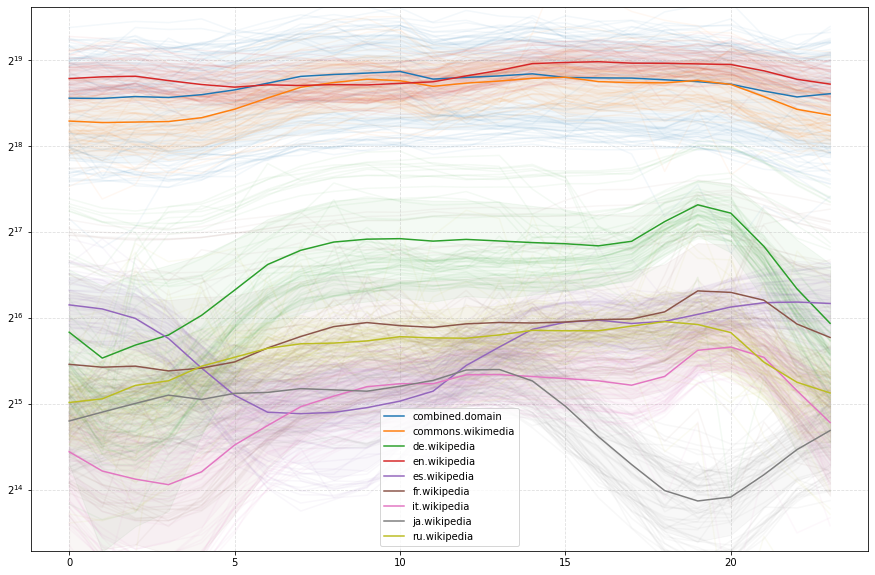

In [454]:
df7 = df6.groupby([df6.index.year, df6.index.day, df6.newDomain, df6.index.hour])["sumCount"].sum()
df7.rename_axis(index=["year", "day", "newDomain", "hour"], inplace=True)

years = df7.index.get_level_values("year").unique().to_numpy()
days = df7.index.get_level_values("day").unique().to_numpy()
domains = df7.index.get_level_values("newDomain").unique().to_list()

fig, ax = plt.subplots(figsize=(15,10))

for year in years:
    for day in days:
        for i, domain in enumerate(domains):
            # print(year, day, domain)
            _, y = getdfcols(df7.loc[year, day, domain])
            lenx = min(len(y), 24)
            x = np.arange(0, lenx)
            ax.plot(x, y, "-", alpha=0.05, color=f"C{i}")


for i, domain in enumerate(domains):
    daymean = df7.loc[:, :, domain].mean(axis=0, level=2)
    daystd = df7.loc[:, :, domain].std(axis=0, level=2)
    ymean = daymean.to_numpy()
    ystd = daystd.to_numpy()
    lenx = min(len(ymean), 24)
    x = np.arange(0, lenx)
    ax.plot(x, ymean, "-", alpha=1, color=f"C{i}", label=domain)
    ax.fill_between(x, ymean+ystd, ymean-ystd, alpha=0.05, color=f"C{i}")

ax.set_yscale("log", base=2)
plt.legend()
ax.set_ylim(0.01 * 1e6, 0.8 * 1e6)
plt.grid(linestyle="--", alpha=0.4, which="both")
plt.show()

In [ ]:
df5 = df2.groupby([df2.index.year, df2.index.day, df2.index.hour])["sumCount"].sum()

In [22]:
def strsplit(s):
    sl = s.split(".")
    if len(sl) == 2:
        return sl
    elif len(sl) == 1:
        return ["", *sl]
    elif len(sl) > 2:
        print(sl)
        return sl[:2]
    else:
        print(sl)

In [28]:
df2[0:100000].apply(lambda r: strsplit(r.domain), axis=1, result_type="expand")

,0,1
date,,
2018-09-01 00:00:00,cs,wiktionary
2018-09-01 00:00:00,tg,wiktionary
2018-09-01 00:00:00,tn,wikipedia
2018-09-01 00:00:00,bh,wikipedia
2018-09-01 00:00:00,la,wikisource
...,...,...
2018-09-03 16:00:00,zh,wikibooks
2018-09-03 16:00:00,ba,wikipedia
2018-09-03 16:00:00,cdo,wikipedia


In [35]:
df2[df2["domain"] == '����']

,trafficType,domain,sumCount
date,,,
2018-09-02 07:00:00,spider,����,1
2018-09-17 10:00:00,spider,����,1
2018-09-21 17:00:00,spider,����,1


## TODO IDEAS

- check 80/20 rule: "20% of topics result in 80% of views and the other 80% get 20% of views"
    - see which numbers there are in reality, then check if these numbers changed during the DDOS atack
    - maybe the attack was directed at smaller pages and then the rule would change

In [48]:
dfdos = pd.read_csv("../../data/small/ddos_topic_attack.csv")
dfdos = dfdos[dfdos["pageID"]!="pageID"]  # weird artefact
dfdos["date"] = pd.to_datetime(dfdos.loc[:, ["year", "month", "day", "hour"]])
dfdos.drop(columns=["year", "month", "day", "hour"], inplace=True)
dfdos.set_index("date", inplace=True)
dfdos = dfdos.astype({"count":int})
dfdos

,domain,title,pageID,accessType,count,trafficType
date,,,,,,
2019-09-07 18:00:00,ar.wikipedia,هجمات_الحرمان_من_الخدمات,-1,mobile-app,2,user
2019-09-07 18:00:00,de.wikipedia,Denial_of_Service,-1,mobile-app,20,user
2019-09-07 18:00:00,pl.wikipedia,DDoS,-1,mobile-app,3,user
2019-09-07 18:00:00,pl.wikipedia,DoS,-1,mobile-app,2,user
2019-09-07 18:00:00,ru.wikipedia,DoS-атака,-1,mobile-app,1,user
...,...,...,...,...,...,...
2019-09-08 00:00:00,en.wikipedia,Denial-of-service_attack,-1,desktop,2,spider
2019-09-08 00:00:00,de.wikipedia,Denial_of_Service,-1,mobile-app,4,user
2018-09-22 02:00:00,en.wikipedia,Denial-of-service_attack,-1,desktop,1,spider


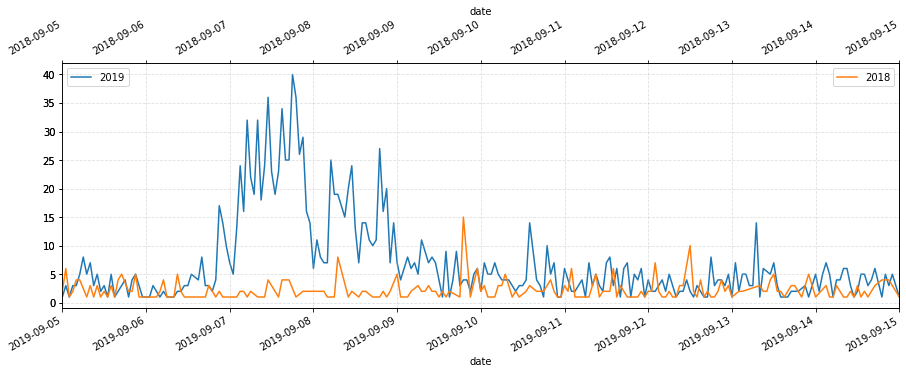

In [47]:
fig, ax1 = plt.subplots(figsize=(15,5))
dfdos[dfdos.index.year==2019].groupby(["date"])["count"].sum().plot(ax=ax1, color="C0", label="2019")
ax2 = ax1.twiny()
dfdos[dfdos.index.year==2018].groupby(["date"])["count"].sum().plot(ax=ax2, color="C1", label="2018")
ax2.legend()
ax1.legend(loc=2)
ax1.set_xlim(datetime.date(2019, 9, 5), datetime.date(2019, 9, 15))
ax2.set_xlim(datetime.date(2018, 9, 5), datetime.date(2018, 9, 15))
plt.grid(linestyle="--", alpha=0.4)
plt.legend()
plt.show()

## Note

The increase in page views of the *DDOS* or *DOS* topic is probbaly due to news coverage, and not due to the DDOS attack itself
--> hence in order to detect **unnoticed** attacks, we can not rely on this..

In [69]:
topn = 100
# doing treshold with top n entries
df_topn = df2[["sumCount", "domain"]].groupby("domain").sum("sumCount").sort_values("sumCount", ascending=False)[0:topn]
df_treshold = df2.domain.isin(df_topn.index).to_frame().rename(columns={"domain": "sumCount"})

df8 = df2.copy()
df8.loc[df_treshold["sumCount"], "newDomain"] = df8[df_treshold["sumCount"]].domain
df8.loc[~df_treshold["sumCount"], "newDomain"] = "combined.domain"
print(len(df8.newDomain.unique()))

101


In [131]:
df9 = df8.groupby([df8.index.year, df8.index.day, "newDomain"]).sum()
df9 = df9.unstack()["sumCount"]

sorted_cols = df9.mean(axis=0).sort_values(ascending=False).index

df9 = df9[sorted_cols]

In [198]:
def normalise(vec): return (vec - np.mean(vec)) / np.std(vec)

df9_normalised = df9.transform(normalise, axis=0)

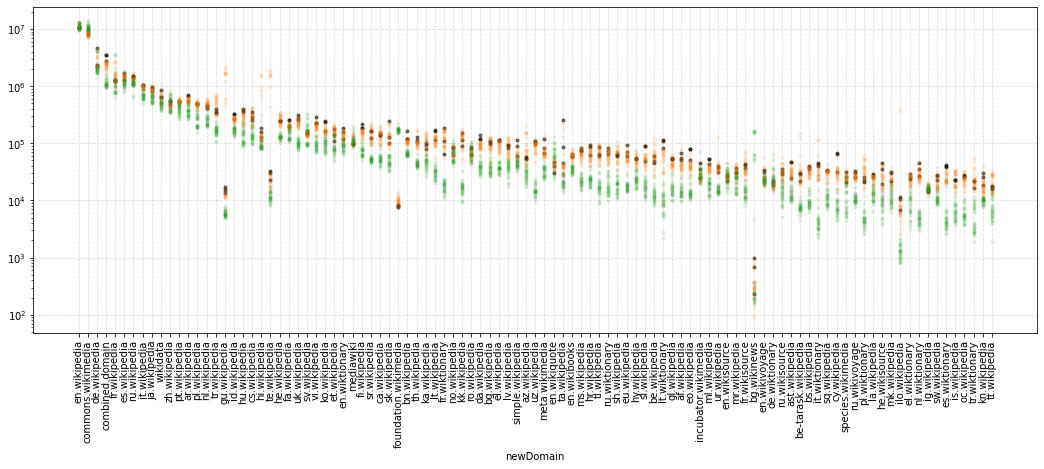

In [192]:
plt.figure(figsize=(18,6))
for idx, row in df9.iterrows():
    i = 1 if (idx[0] == 2018) else 2
    row.plot(alpha=0.1, color=f"C{i}", marker=".", linestyle="")

    if ((idx[0] == 2018) and (idx[1] in [6,7,8])):  # attack
        row.plot(alpha=0.5, color="black", marker=".", linestyle="")

plt.xticks(range(len(row.index)), row.index, rotation=90)

plt.yscale("log")
plt.grid(alpha=0.4, linestyle="--")
# plt.legend()
plt.show()

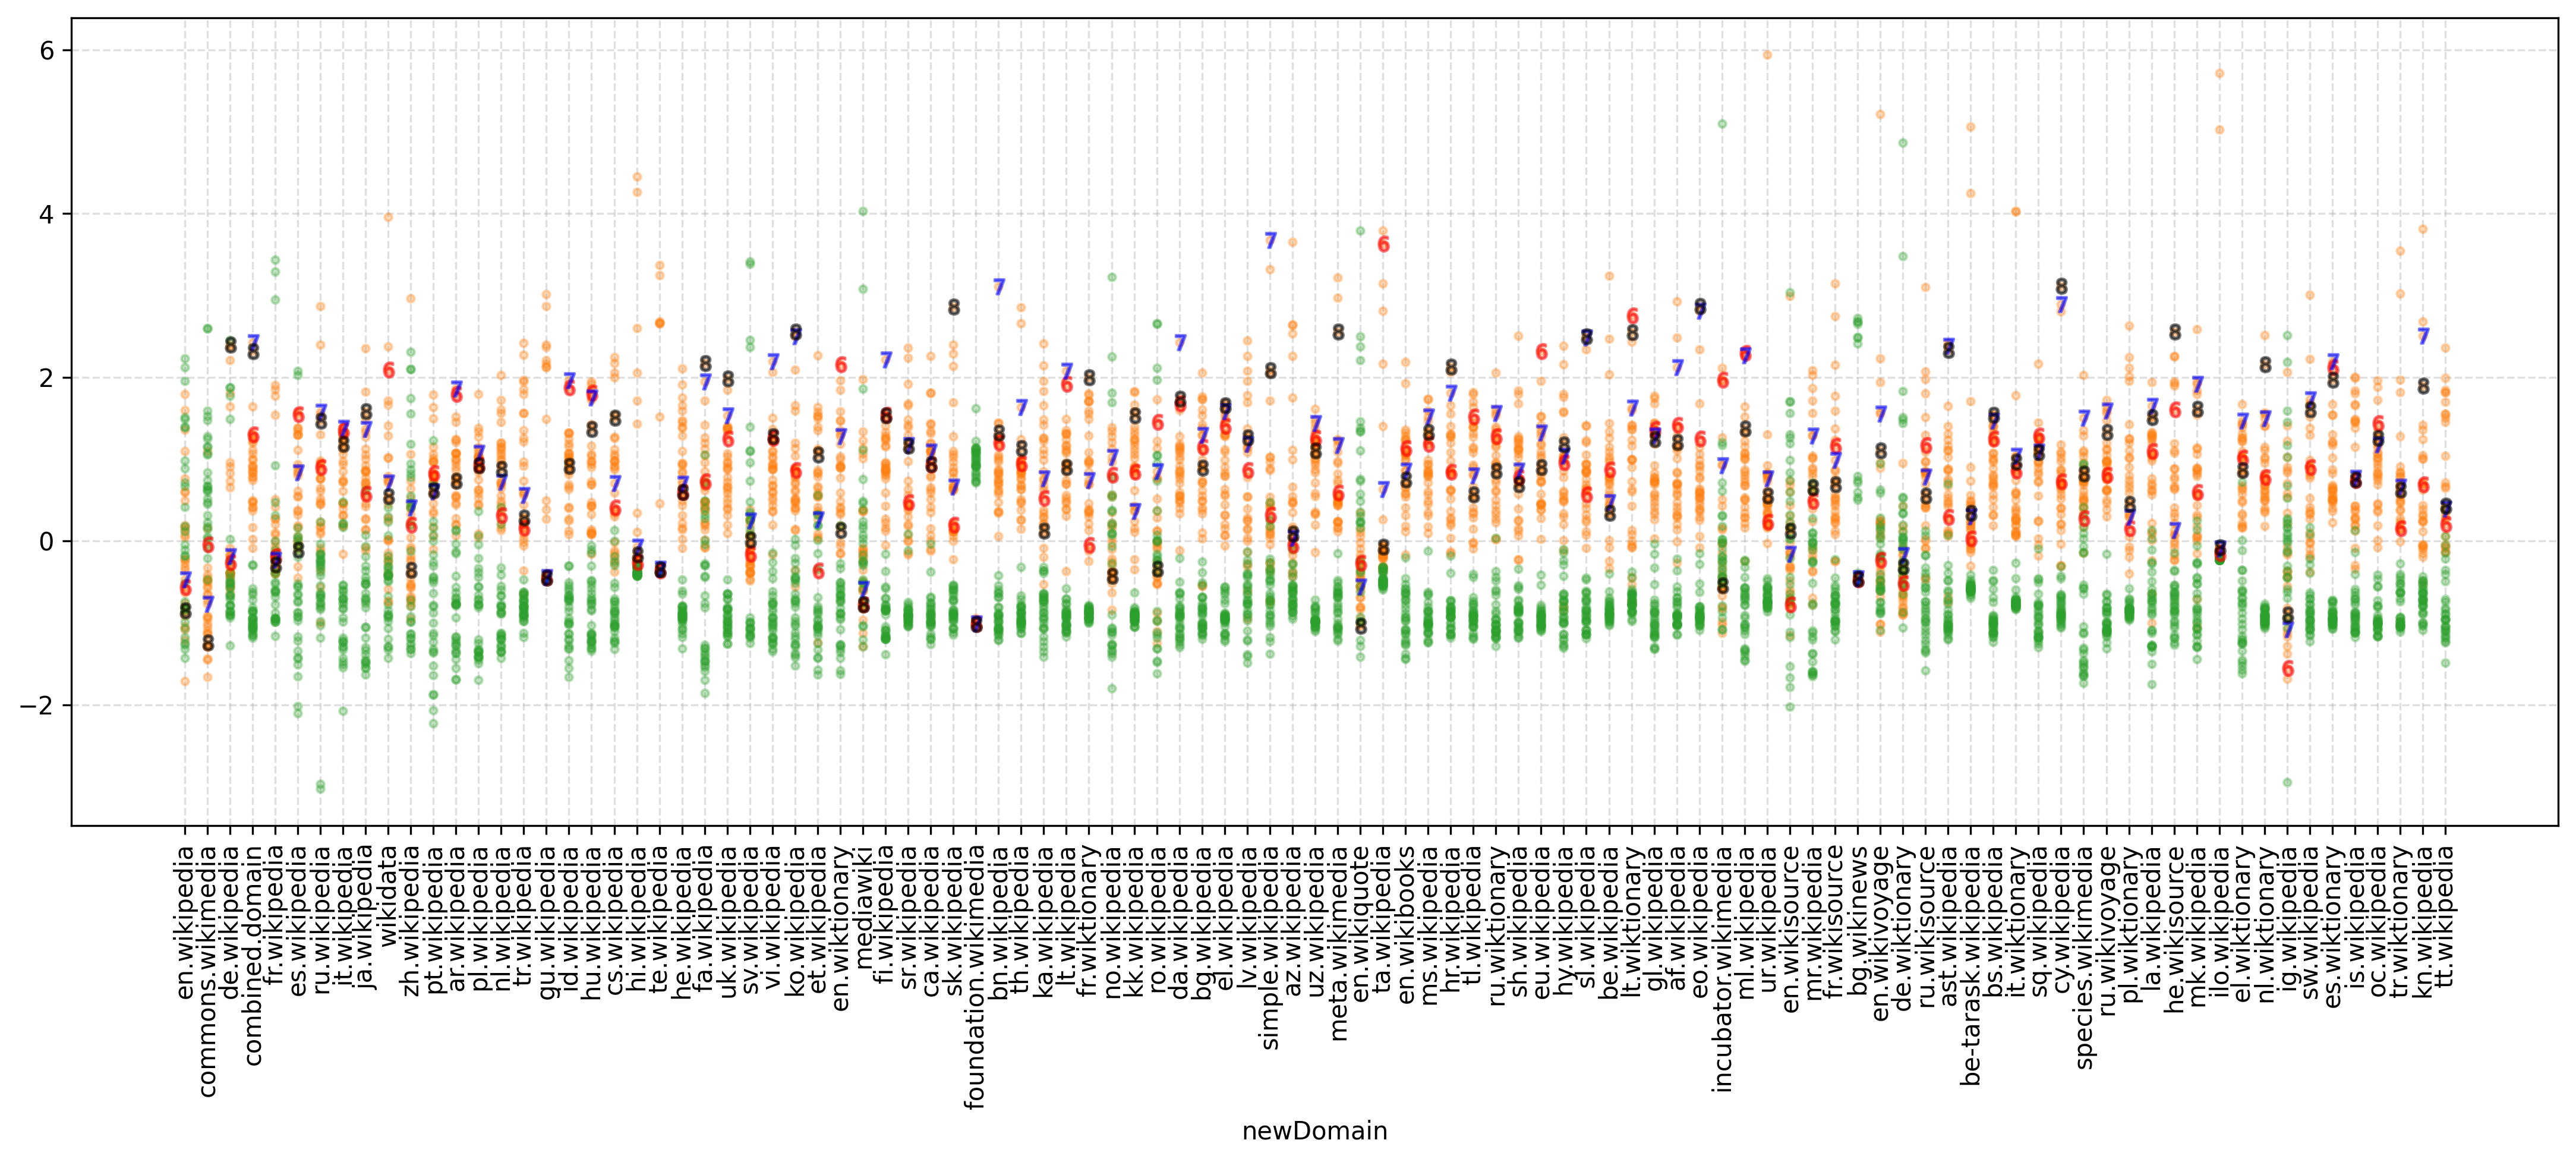

In [209]:
plt.figure(figsize=(18,6), dpi=300)
for idx, row in df9_normalised.iterrows():
    i = 1 if (idx[0] == 2018) else 2
    row.plot(alpha=0.3, color=f"C{i}", marker=".", linestyle="")

for idx, row in df9_normalised.iterrows():
    if ((idx[0] == 2018) and (idx[1] in [6,7,8])):  # attack
        colordic = {6:"red", 7:"blue", 8:"black"}
        row.plot(alpha=0.5, color=colordic[idx[1]], marker=f"${idx[1]}$", linestyle="")

plt.xticks(range(len(row.index)), row.index, rotation=90)

plt.grid(alpha=0.4, linestyle="--")
# plt.legend()
plt.show()

In [121]:
df9.loc[sorted_cols.to_list()]

KeyError: "['en.wikipedia' 'commons.wikimedia' 'de.wikipedia' 'combined.domain'\n 'fr.wikipedia' 'es.wikipedia' 'ru.wikipedia' 'it.wikipedia'\n 'ja.wikipedia' 'wikidata' 'zh.wikipedia' 'pt.wikipedia' 'ar.wikipedia'\n 'pl.wikipedia' 'nl.wikipedia' 'tr.wikipedia' 'gu.wikipedia'\n 'id.wikipedia' 'hu.wikipedia' 'cs.wikipedia' 'hi.wikipedia'\n 'te.wikipedia' 'he.wikipedia' 'fa.wikipedia' 'uk.wikipedia'\n 'sv.wikipedia' 'vi.wikipedia' 'ko.wikipedia' 'et.wikipedia'\n 'en.wiktionary' 'mediawiki' 'fi.wikipedia' 'sr.wikipedia' 'ca.wikipedia'\n 'sk.wikipedia' 'foundation.wikimedia' 'bn.wikipedia' 'th.wikipedia'\n 'ka.wikipedia' 'lt.wikipedia' 'fr.wiktionary' 'no.wikipedia'\n 'kk.wikipedia' 'ro.wikipedia' 'da.wikipedia' 'bg.wikipedia'\n 'el.wikipedia' 'lv.wikipedia' 'simple.wikipedia' 'az.wikipedia'\n 'uz.wikipedia' 'meta.wikimedia' 'en.wikiquote' 'ta.wikipedia'\n 'en.wikibooks' 'ms.wikipedia' 'hr.wikipedia' 'tl.wikipedia'\n 'ru.wiktionary' 'sh.wikipedia' 'eu.wikipedia' 'hy.wikipedia'\n 'sl.wikipedia' 'be.wikipedia' 'lt.wiktionary' 'gl.wikipedia'\n 'af.wikipedia' 'eo.wikipedia' 'incubator.wikimedia' 'ml.wikipedia'\n 'ur.wikipedia' 'en.wikisource' 'mr.wikipedia' 'fr.wikisource'\n 'bg.wikinews' 'en.wikivoyage' 'de.wiktionary' 'ru.wikisource'\n 'ast.wikipedia' 'be-tarask.wikipedia' 'bs.wikipedia' 'it.wiktionary'\n 'sq.wikipedia' 'cy.wikipedia' 'species.wikimedia' 'ru.wikivoyage'\n 'pl.wiktionary' 'la.wikipedia' 'he.wikisource' 'mk.wikipedia'\n 'ilo.wikipedia' 'el.wiktionary' 'nl.wiktionary' 'ig.wikipedia'\n 'sw.wikipedia' 'es.wiktionary' 'is.wikipedia' 'oc.wikipedia'\n 'tr.wiktionary' 'kn.wikipedia' 'tt.wikipedia'] not in index"

In [94]:
plt.plot(row.to_numpy())

AttributeError: 'tuple' object has no attribute 'to_numpy'

In [109]:
sorted_cols

NameError: name 'sorted_cols' is not defined